In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from statsmodels.tsa.deterministic import CalendarFourier

## 1. Global parameters

In [3]:
features_dir = '../data/01_raw/dengue_features_train.csv'
labels_dir = '../data/01_raw/dengue_labels_train.csv'
test_dir = '../data/01_raw/dengue_features_test.csv'


test_output_dir = 'model-both-cities-output.csv'


## 2. Functions for train input and test output

In [5]:
def get_train_data(features_dir, labels_dir):
    """ 
    Input:
        str to csv with train features and labels

    Output:
         X, y
    
    """
    features = pd.read_csv(features_dir)
    labels = pd.read_csv(labels_dir)

    data = features.merge(labels)
    
    X = data.drop(columns=['total_cases'])
    y = data.loc[:,'total_cases']
    print("Loading of training data finished.\n")
        
    return data, X, y


def get_test_output(X_test, predictions, indexes = ['city', 'year', 'weekofyear'], file_dir = '../data/output.csv'):
    """
    Input:
        X_test - 
        predictions - for both cities indexed as X_test requires it and 
                        with the same number of rows as X_test. 
        indexes (List(str)) - By default the columns of X_test for the required format,
                        i.e., ['city', 'year', 'weekofyear'];
                     
        file_dir (str) - directory with the filename of the output csv file;
                         Give an empty string if saving the output is not desired.
        
    Returns:
        output_df (pd.DataFrame) - Dataframe with formatted results
        csv file
    """

    # 2. Make the dictionary for the output dataframe format.
    out_dict = {}
    for index in indexes:
        out_dict[index] = X_test[index]

    out_dict['total_cases'] =  np.round(predictions).astype(int) 
    output_df = pd.DataFrame.from_dict(out_dict).set_index(indexes)
    
    # 3. Save predictions in a csv file ready for submission.
    if file_dir:
        print("Saved predictions in competition file format in path {} . /n".format(file_dir))
        output_df.to_csv(file_dir)
        print('\n')

    return output_df
    
    

## 3 Preprocessing of X with lag and fourier seasonality

In [8]:
lag_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

def make_lags(X, columns, lags=8):
    new_dict = {}
    labels = []
    for column in columns:
        for lag in range(1,lags+1):
            #X_new.loc[:, column+'_lag_{}'.format(lag)] = X[column].shift(lag)
            new_dict[column+'_lag_{}'.format(lag)]= X[column].shift(lag)
            labels.append(column+'_lag_{}'.format(lag))

    X_new = pd.DataFrame(new_dict, columns=labels, index=X.index)
    return pd.concat([X, X_new], axis=1)


def get_seasonality(X, time_column='week_start_date', format='%Y-%m-%d'):
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    #return_cols = [time_column, 'year', 'month', 'dayofyear', 'weekofyear']
    #X_fourier = X_new[time_column]
    
    fourier_year = CalendarFourier(freq='A', order=5)
    fourier_month = CalendarFourier(freq='M', order=6)
    fourier_week = CalendarFourier(freq='W', order=10)
    fourier_day = CalendarFourier(freq='D', order=3)
    df_year = fourier_year.in_sample(X_new[time_column]).set_index(X_new.index)
    df_month = fourier_month.in_sample(X_new[time_column]).set_index(X_new.index)
    df_week = fourier_week.in_sample(X_new[time_column]).set_index(X_new.index)
    df_day = fourier_day.in_sample(X_new[time_column]).set_index(X_new.index)

    ym = pd.concat([df_year,df_month], axis=1)
    wd = pd.concat([df_week,df_day], axis=1)
    ymwd = pd.concat([ym, wd], axis=1)

    return pd.concat([X_new, ymwd], axis=1)

def preprocess_with_season(X, time_column='week_start_date', format='%Y-%m-%d', lag_cols = lag_cols):
    # Timed features.
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    X_new['year'] =  X_new[time_column].apply(lambda x: x.year)
    X_new.loc[:,'month'] = X_new[time_column].apply(lambda x: x.month)
    X_new.loc[:,'dayofyear'] = X_new[time_column].apply(lambda x: x.dayofyear)
    X_new['weekofyear'] =  X_new[time_column].apply(lambda x: x.weekofyear)

    # Add lags
    X_lagged = make_lags(X_new, columns=lag_cols)

    # Add seasonality
    X_seasoned = get_seasonality(X_lagged)

    numerical_cols = list(X_seasoned.select_dtypes(include=[np.number]).columns)
    categorical_cols = list(X_seasoned.select_dtypes(include=[object]).columns)

    # Simple imputer seems to do better than KNNImputer in this case
    numerical_transformer = Pipeline(
        steps =[('imputer', SimpleImputer())]
        )

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return pd.DataFrame(preprocessor.fit_transform(X_seasoned), columns=numerical_cols + ['iq', 'sj'])
    

## 4. Final pipeline

In [11]:
data, X, y = get_train_data(features_dir, labels_dir)

X_preprocessed_season = preprocess_with_season(X, time_column='week_start_date', format='%Y-%m-%d', lag_cols = lag_cols)

model_season = xgb.XGBRegressor(max_depth=3,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

xgb_reg_season = model_season.fit(X_preprocessed_season, y)

prediction_train_season =  xgb_reg_season.predict(X_preprocessed_season)
score = mean_absolute_error(y,prediction_train_season)
print("Score: {}".format(score))

X_test = pd.read_csv(test_dir)
X_test_preprocessed_season = preprocess_with_season(X_test)

results_season = xgb_reg_season.predict(X_test_preprocessed_season)
out_df_season = get_test_output(X_test, results_season, indexes = ['city', 'year', 'weekofyear'], file_dir = test_output_dir)


Loading of training data finished.



/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


Score: 7.5282184688353935
Saved predictions in competition file format in path model-both-cities-output.csv . /n




/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


### Visual investigation of the train accuracy on multiple scales

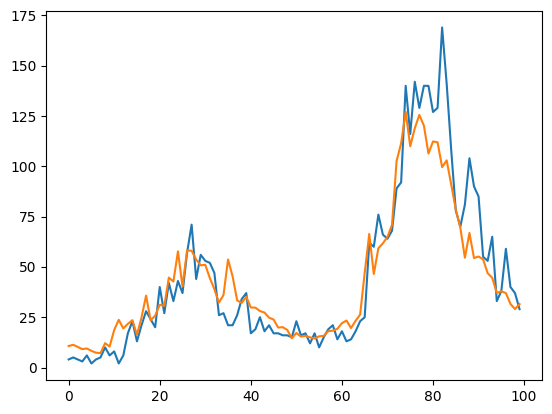

In [10]:
nr = 100
x_line = np.arange(len(y))
plt.plot(x_line[0:nr], y[0:nr], label= "original")
plt.plot(x_line[0:nr], prediction_train_season[0:nr], label= "prediction")
plt.show()

## Gridsearch Results used in the main pipeline
{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'reg:absoluteerror'}

In [67]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [68]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))



In [88]:

param_tuning = {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3,4, 5],
        'n_estimators' : [50, 100, 200],
        'objective': ['reg:absoluteerror']
    }


In [89]:
gsearch = GridSearchCV(estimator = xgb_reg_season,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

#gsearch.fit(X_preprocessed_season,y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, ma...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'objective': ['reg:absoluteerror']},
             scoring='neg_mean_absolute_error', verbose=1)

In [78]:
gsearch.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'reg:absoluteerror'}